# Nutrient profiling system based on FSAm-NPS  

Purpose: Explore data on food nutriention by process and analyse the data from nutrient dataset which use nutrient profiling to score and rank foods and products to acquire information and knowledge.

Datasets : https://www.kaggle.com/datasets/trolukovich/nutritional-values-for-common-foods-and-products
Citation: Deschasaux M, Huybrechts I, Murphy N, Julia C, Hercberg S, et al. (2018) Nutritional quality of food as represented by the FSAm-NPS nutrient profiling system underlying the Nutri-Score label and cancer risk in Europe: Results from the EPIC prospective cohort study. PLOS Medicine 15(9): e1002651. https://doi.org/10.1371/journal.pmed.1002651

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import re

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

In [51]:
# Load data from csv

nutrition_df = pd.read_csv("Dataset/nutrition.csv")
nutrition_df.head()

,Unnamed: 0,name,serving_size,calories,total_fat,saturated_fat,cholesterol,sodium,choline,folate,...,fat,saturated_fatty_acids,monounsaturated_fatty_acids,polyunsaturated_fatty_acids,fatty_acids_total_trans,alcohol,ash,caffeine,theobromine,water
0,0,Cornstarch,100 g,381,0.1g,NaN,0,9.00 mg,0.4 mg,0.00 mcg,...,0.05 g,0.009 g,0.016 g,0.025 g,0.00 mg,0.0 g,0.09 g,0.00 mg,0.00 mg,8.32 g
1,1,"Nuts, pecans",100 g,691,72g,6.2g,0,0.00 mg,40.5 mg,22.00 mcg,...,71.97 g,6.180 g,40.801 g,21.614 g,0.00 mg,0.0 g,1.49 g,0.00 mg,0.00 mg,3.52 g
2,2,"Eggplant, raw",100 g,25,0.2g,NaN,0,2.00 mg,6.9 mg,22.00 mcg,...,0.18 g,0.034 g,0.016 g,0.076 g,0.00 mg,0.0 g,0.66 g,0.00 mg,0.00 mg,92.30 g
3,3,"Teff, uncooked",100 g,367,2.4g,0.4g,0,12.00 mg,13.1 mg,0,...,2.38 g,0.449 g,0.589 g,1.071 g,0,0,2.37 g,0,0,8.82 g
4,4,"Sherbet, orange",100 g,144,2g,1.2g,1mg,46.00 mg,7.7 mg,4.00 mcg,...,2.00 g,1.160 g,0.530 g,0.080 g,1.00 mg,0.0 g,0.40 g,0.00 mg,0.00 mg,66.10 g


## Processing dataframe

In [52]:
# Drop unused columns
nutrition_df = nutrition_df.drop(['Unnamed: 0'], axis=1)

# Check Null column
null_field = nutrition_df.columns[(nutrition_df.isnull().sum()) > 0]
nutrition_df[nutrition_df.isnull().any(axis=1)][[null_field[0]]]

,saturated_fat
0,NaN
2,NaN
10,NaN
11,NaN
12,NaN
...,...
8655,NaN
8662,NaN
8694,NaN
8764,NaN


In [53]:
# Fill null value and change type to string 
nutrition_df['saturated_fat'] = nutrition_df['saturated_fat'].fillna(0)
nutrition_df['saturated_fat'] = nutrition_df['saturated_fat'].astype(str)

# Change some columns name
nutrition_df = nutrition_df.rename(columns={'irom': 'iron', 'zink': 'zinc', 'monounsaturated_fatty_acids': 'monounsaturated_fat'})

In [54]:
# Check serving size for comparing nutrient
nutrition_df.groupby('serving_size').count()

,name,calories,total_fat,saturated_fat,cholesterol,sodium,choline,folate,folic_acid,niacin,...,fat,saturated_fatty_acids,monounsaturated_fat,polyunsaturated_fatty_acids,fatty_acids_total_trans,alcohol,ash,caffeine,theobromine,water
serving_size,,,,,,,,,,,,,,,,,,,,,
100 g,8789,8789,8789,8789,8789,8789,8789,8789,8789,8789,...,8789,8789,8789,8789,8789,8789,8789,8789,8789,8789


In [55]:
# remove units and change to float for calculating purpose

nutrition_df['vitamin_a'] = nutrition_df['vitamin_a'].str.replace('mcg', '')

for col in ['vitamin_a','vitamin_d']:
    nutrition_df[col] = nutrition_df[col].map(lambda x: x.replace('IU','')).astype(float)
    
for col in ['vitamin_c','vitamin_e','thiamin','riboflavin','calcium','iron','zinc','potassium','sodium','choline','copper','magnesium', 'manganese','phosphorous']:   
    nutrition_df[col] = nutrition_df[col].map(lambda x: x.replace('mg','')).astype(float)
    
for col in ['total_fat','protein','carbohydrate','fat','saturated_fat','sugars','fiber','monounsaturated_fat']:   
    nutrition_df[col] = nutrition_df[col].map(lambda x: x.replace('g','')).astype(float)
    
for col in ['vitamin_b12','folate']:   
    nutrition_df[col] = nutrition_df[col].map(lambda x: x.replace('mcg','')).astype(float) 

In [56]:
# Define Category function to define type of food and getindex function
def setCategory(df, string_category, category):
    if(category == 'drink'):
        index_list = df[df['name'].str.contains(('|').join(string_category), flags=re.I)].index
    elif(category == 'fruit'):
        index_list = df[(df['category'] != 'drinks') & (df['name'].str.contains(('|').join(string_category), flags=re.I)) & (df['name'].str.contains('raw', flags=re.I))].index
    else:
        index_list = df[(df['category'] != 'drinks') & (df['name'].str.contains(('|').join(string_category), flags=re.I))].index
    
    df.loc[index_list,['category']] = category
    
def getIndex(string_drink):
    index_list = nutrition_df[nutrition_df['name'].str.contains(('|').join(string_drink), flags=re.I)].index
    return index_list

In [57]:
# Define ingredient for each category for using in search and assign category
# Category : fruit / vegetable / nuts / legume / food / drink / cheese

test_category_food = nutrition_df.copy()
test_category_food['category'] = ''

drink = ['drink', 'beverage', 'juice', 'milk']

fruits_name = ['watermelon','Banana','apple','orange','Grape','Melon','Peache','Papaya',
 'Pear','Kiwi','Lime','Tangerine','Blueberries','Blueberry','Cherries','Cherry','Pineapple',
 'Passion fruit','fruit','Grapefruit','Fig','Cranberries','Cranberry','Lemon','Mango','Pomegranate',
 'Pumpkin','Lychee','Apricot']

legumes= 'bean|peas|peanut|lentils|hummus|chickpeas|chickpea|soybeans|tofu|alfalfa sprouts|bean sprouts|green beans'
legumes_split = legumes.split('|')
legumes_name = [s.rstrip('s') for s in legumes_split]

vegetables = 'vegetable|amaranth leaves|arugula|rocket|basil|beet greens|bitter melon leaves|bok choy|broccoli|broccoli rabe|rapini|broccolini|chamnamul|chard|chrysanthemum leaves| cilantro|collard greens|cress|dandelion greens|dark-green leafy lettuce|endive|escarole|kale|lambsquarters|mesclun|mixed greens|mustard greens|nettles|poke greens|romaine lettuce|spinach|Swiss chard|taro leaves|turnip greens|watercress|lettuce|acorn squash|butternut squash|calabaza|carrot|carrot|hubbard squash|kabocha squash|pimento/pimiento|pumpkin|red and orange bell peppers|red chili peppers|red peppers, sweet|sweet potatoes|tomatoes|100% vegetable juice|winter squash|squash|bell pepper|orange bell pepper|red bell pepper|breadfruit|burdock root|cassava|corn|fufu|hominy|jicama|lotus root|parsnips|plantains|potatoes|salsify|tapioca|taro root|dasheen or yautia|water chestnuts|yams|yucca|sweet potatoes|sweet potato|arrowroot|artichokes|asparagus|avocado|bamboo shoots|beets|bitter melon|bitter gourd|balsam pear|broccoflower|Brussels sprouts|cabbage|cactus pads|nopales|cauliflower|cauliflower,|celeriac|celery|chayote|mirliton|chives|cucumber|daikon|drumstick pods|moringa|eggplant|fennel bulb|fiddlehead ferns|garlic|ginger root|green peppers|hearts of palm|Jerusalem artichokes|sunchokes|jute|kohlrabi|leeks|luffa|Chinese okra|mushrooms|okra|onions|pattypan squash|purslane|radicchio|radishes|red cabbage|rutabaga|seaweed|scallions|snow peas|sorrel|spaghetti squash|tomatillos|turnips|wax beans|yellow squash|zucchini'
vegetables_split = vegetables.split('|')
vegetables_name = [s.rstrip('s') for s in vegetables_split]

nuts = 'nut|peacan|almonds|almond butter|Brazil nuts|cashew butter|cashews|chestnuts|chia seeds|flax seeds|hazelnuts|filberts|macadamia nuts|mixed nuts|peanut butter|peanuts|pecans|pine nuts|pistachios|pumpkin seeds|sesame butter or paste|tahini|sesame seeds|sunflower butter|sunflower seeds|walnuts|nuts'
nuts_split = nuts.split('|')
nuts_name = [s.rstrip('s') for s in nuts_split]

cheese_name = ['cheese']

category_list = [drink,fruits_name,vegetables_name,nuts_name,legumes_name,cheese_name]
category_name = ['drinks','fruits','vegetables','nuts','legumes','cheese']

In [58]:
# set Category
for i in range(len(category_name)):
    setCategory(test_category_food, category_list[i], category_name[i])

# The rest that not contain following ingredient set as foods
restfood_index = test_category_food[test_category_food['category'] == ''].index
test_category_food.loc[restfood_index,['category']] = 'food'

In [59]:
# Create new column that convert Caloreis to Energy(kJ) : 1 Calories 4.184 KJ
test_category_food['Energy (kJ)'] = np.round(test_category_food['calories'] * 4.184)

# Count ingredient to use in assign Fruits/vegetables/legumes/nuts (%)
test_category_food['ingredient_length'] = test_category_food['name'].apply(lambda x: len(x.split(',')))

In [60]:
# Check category
#test_category_food.groupby('category').count()

## FSAm-NPS score calculation

#### As for Fruits/vegetables/legumes/nuts (%) need to use V point to indicate score based on their ingredients separately, so the food assign value assume base on number of ingredients meaning that the more ingredients in the food are less of FVLN value
If their ingredient consist 
- equal or less than 3 then their % is > 80
- equal to 4 then their % is > 60
- equal to 5 then their % is > 40
- not contain following ingredient then their % is <= 40

In [61]:
# As category food is not consist of Fruits/vegetables/legumes/nuts ingredients suppose the value to <=40
def assignFVLN(category, length):
    if category != 'food':
        if length <= 3:
            return '>80'
        elif length == 4:
            return '>60'
        elif length == 5:
            return '>40'
        else:
            return '<=40'
    else:
        return '<=40'
    
test_category_food['FVLN (%)'] = test_category_food.apply(lambda x: assignFVLN(x['category'],x['ingredient_length']), axis=1)

### According to FSAm-NPS score computation at food/beverage level 
https://journals.plos.org/plosmedicine/article?id=10.1371/journal.pmed.1002651#sec008

Calculate the nutritional quality of food with FSAm-NPS nutrient profiling system

### Example of calculate Nutrient points on food only (drinks score has slightly change in calculation value)
A points 
Total A points = (points for energy) + (points for saturated fat) + (points for total sugar) + (points for sodium)

C points
Total C points = (points for fruits/vegetables/legumes/nuts) + (points for fibres) + (points for proteins)

### Overall score computation

• If Total A points <11, then FSAm-NPS score =Total A points – Total C points

• If Total A points ≥11,

    o If points for fruits/vegetables/legumes/nuts =5, then FSAm-NPS score =Total A points – Total C points
    o Else if points for fruits/vegetables/legumes/nuts <5, then FSAm-NPS score = Total A points – (points
    for fibre + points for fruits/vegetables/legumes/nuts). 

In [62]:
def calculateTotalPointA(category, energy, fat, sugar, sodium):
    
    total_points_a = 0
    energy_point = 0
    fat_point = 0
    sugar_point = 0
    sodium_point = 0
    if (category != 'drinks'):
        if np.floor((energy / 335) - 0.0001) >= 10:
            energy_point += 10
        else:
            energy_point += np.floor( (energy / 335) - 0.0001)
    
        if np.floor((fat / 1) - 0.0001) >= 10:
            fat_point += 10
        else:
            fat_point += np.floor((fat / 1) - 0.0001)
        
        if np.floor((sugar / 4.55) - 0.0001) >= 10:
            sugar_point += 10
        else:
            sugar_point += np.floor((sugar / 4.5) - 0.0001)
        
        if np.floor((sodium / 90) - 0.0001) >= 10:
            sodium_point += 10
        else:
            sodium_point += np.floor((sodium / 90) - 0.0001)
    
    else:
        if np.ceil((energy / 30)) >= 10:
            energy_point += 10
        else:
            energy_point += np.ceil( (energy / 30))
    
        if np.floor((fat / 1) - 0.0001) >= 10:
            fat_point += 10
        else:
            fat_point += np.floor((fat / 1) - 0.0001)
        
        if np.ceil((sugar / 1.5)) >= 10:
            sugar_point += 10
        else:
            sugar_point += np.ceil((sugar / 1.5))
        
        if np.floor((sodium / 90) - 0.0001) >= 10:
            sodium_point += 10
        else:
            sodium_point += np.floor((sodium / 90) - 0.0001)
    
    # set back minus value from np.floor
    if energy_point < 0: energy_point = 0
    if fat_point < 0: fat_point = 0
    if sugar_point < 0: sugar_point = 0  
    if sodium_point < 0: sodium_point = 0 
        
    total_points_a = energy_point + fat_point + sugar_point + sodium_point
    return total_points_a
    
    
def calculateNutriScore(category, total_points_a, flvn, fiber, protein):    
    
    nutri_points = 0
    total_points_c = 0
    flvn_point = 0
    fiber_point = 0
    protein_point = 0
    if (category != 'drinks'):
        
        if flvn == '<=40':
            flvn_point += 0
        elif flvn == '>40':
            flvn_point += 1
        elif flvn == '>60':
            flvn_point += 2
        elif flvn == '>80':
            flvn_point += 5

        if np.floor((fiber / 0.7) - 0.0001) >= 5:
            fiber_point += 5
        else:
            fiber_point += np.floor((fiber / 0.7) - 0.0001)
            
        if np.floor((protein / 1.6) - 0.0001) >= 5:
            protein_point += 5
        else:
            protein_point += np.floor((fiber / 1.6) - 0.0001)    
            
    else:
        
        if flvn == '<=40':
            flvn_point += 0
        elif flvn == '>40':
            flvn_point += 2
        elif flvn == '>60':
            flvn_point += 4
        elif flvn == '>80':
            flvn_point += 10
            
        if np.floor((fiber / 0.7) - 0.0001) >= 5:
            fiber_point += 5
        else:
            fiber_point += np.floor((fiber / 0.7) - 0.0001)
            
        if np.floor((protein / 1.6) - 0.0001) >= 5:
            protein_point += 5
        else:
            protein_point += np.floor((fiber / 1.6) - 0.0001)        
            
            
    # set back value from np.floor    
    if fiber_point < 0: fiber_point = 0
    if protein_point < 0: protein_point = 0

    total_points_c = flvn_point + fiber_point + protein_point

    # Calculate Nutri Score based on FSAm-NPS score computation
    
    if category == 'cheese':
        nutri_points = total_points_a - total_points_c
    elif category == 'drinks':
        if (total_points_a < 11) or (flvn_point == 10):
            nutri_points = total_points_a - total_points_c
        else:
            nutri_points = total_points_a - (fiber_point+flvn_point)
    else: 
        if (total_points_a < 11) or (flvn_point == 5):
            nutri_points = total_points_a - total_points_c
        else:
            nutri_points = total_points_a - (fiber_point+flvn_point)
    
    return nutri_points

In [63]:
# Calculate points_a and final NutriScore
test_category_food['points_a'] = test_category_food.apply(lambda x: calculateTotalPointA(x['category'],x['Energy (kJ)'], x['saturated_fat'], x['sugars'], x['sodium']), axis=1)
test_category_food['NutriScore'] = test_category_food.apply(lambda x: calculateNutriScore(x['category'],x['points_a'],x['FVLN (%)'], x['fiber'], x['protein']), axis=1)

In [64]:
# Check NutriScore Column
test_category_food[['name','Energy (kJ)','category','points_a','NutriScore']][5:10]

,name,Energy (kJ),category,points_a,NutriScore
5,"Cauliflower, raw",105.0,vegetables,0.0,-8.0
6,"Taro leaves, raw",176.0,vegetables,0.0,-12.0
7,"Lamb, raw, ground",1180.0,food,12.0,12.0
8,"Cheese, camembert",1255.0,cheese,22.0,12.0
9,Vegetarian fillets,1213.0,food,10.0,0.0


### FSAm-NPS score and Attribution of Nutri-Score

Foods points

[<-1] = 0 (Highest nutritional quality) 

[0-2] = 1

[3-10] = 2 (Medium nutritional quality)

[11-18] = 3

[>=19] = 4 (Lowest nutritional quality)


Drinks points

[Water] = 0 (Highest nutritional quality)

[<= 1] = 1

[2-5] = 2 (Medium nutritional quality)

[6-9] = 3

[>=10] = 4 (Lowest nutritional quality)

In [65]:
def defineNutriRANK(category, nutriscore):
    
    score = int(nutriscore)
    ranking = ''
    
    if category != 'drinks':
        if score < 0: ranking = 'Highest'        
        if (score >= 0) & (score < 3): ranking = 'High'     
        if (score > 2) & (score < 11): ranking = 'Medium'     
        if (score > 10) & (score < 19): ranking = 'Low'        
        if score > 18: ranking = 'Lowest'    
            
    else:
        if score < 2: ranking = 'High'
        if (score >= 2) & (score < 6): ranking = 'Medium'  
        if (score > 5) & (score < 10): ranking = 'Low'
        if score >= 10: ranking = 'Lowest'
            
    return ranking

In [66]:
# Create NutriRank column for easy to intrepret
test_category_food['NutriRank'] = test_category_food.apply(lambda x: defineNutriRANK(x['category'],x['NutriScore']), axis=1)

In [67]:
# Check NutriRank Column 
test_category_food[['name','Energy (kJ)','category','points_a','NutriScore','NutriRank']][10:20]

,name,Energy (kJ),category,points_a,NutriScore,NutriRank
10,"PACE, Picante Sauce",105.0,food,9.0,4.0,Medium
11,"Goji berries, dried",1460.0,food,17.0,12.0,Low
12,"Mango nectar, canned",213.0,fruits,2.0,-3.0,Highest
13,"Crackers, rusk toast",1703.0,food,8.0,3.0,Medium
14,"Chicken, boiled, feet",900.0,food,5.0,0.0,High
15,"Quail, raw, meat only",561.0,food,2.0,-3.0,Highest
16,"Pie, lemon, fried pies",1322.0,fruits,9.0,0.0,High
17,"Peppers, raw, jalapeno",121.0,food,0.0,-4.0,Highest
18,"Winged bean tuber, raw",619.0,legumes,1.0,-9.0,Highest
19,"Salami, turkey, cooked",720.0,food,14.0,14.0,Low


In [68]:
# Define NutriRankNumber # Not use
def defineNutriRANKnumber(rank):
    rank_number = 0
    if rank == 'Highest': rank_number = 4
    if rank == 'High': rank_number = 3
    if rank == 'Medium': rank_number = 2
    if rank == 'Low': rank_number = 1
    if rank == 'Lowest': rank_number = 0
    return rank_number
test_category_food['NutriRank(number)'] = test_category_food.apply(lambda x: defineNutriRANKnumber(x['NutriRank']), axis=1)

In [69]:
# Plot bar chart to compare nutrion value for each nutrient group

def checkNutrient(rank_array,ranker,selected_value,category):
    ind = np.arange(len(rank_array))  
    width = 0.2      
    total_value = [[0] * len(rank_array) for i in range(len(rank_array[0]))]
    rects = np.zeros_like(total_value).astype(object)
    bar_color = ['r','g','b','y']
    
    fig = plt.figure(figsize=(12, 5.5))
    ax = fig.add_subplot(111)

    for i in range(len(rank_array[0])):
        total_value[i] = [np.round(val[i],1) for val in rank_array]
    
    for i,val in enumerate(total_value): 
        rects[i] = ax.bar(ind + (i*width), val, width, color=bar_color[i])
    
    if(category == 'calories'): 
        ax.set_ylabel('Calories')
        plt.title("Mean of Calories by nutrient rank")
        
    if(category == 'nutrient'): 
        ax.set_ylabel('Grams (g)')
        plt.title("Mean of Macronutrients by nutrient rank")    
     
    if(category == 'minerals'): 
        ax.set_ylabel('MilliGrams (mg)')
        plt.title("Mean of Minerals by nutrient rank")    
        
    if(category == 'vitamins'):
        ax.set_ylabel('vitamin[B12(mcg), C(mg), D(IU), E(mg)]')
        plt.title("Mean of Vitamins by nutrient rank")   
        
    ax.set_xticks(ind+width)
    ax.set_xticklabels([rank for rank in ranker])        
    ax.legend(([rec[0] for rec in rects]), ([sel for sel in selected_value]),loc='upper left')
    
    for j in range(len(rects)):
        for rec in rects[j]:
            h = rec.get_height()
            ax.text(rec.get_x()+rec.get_width()/2. +(0.0), 1.02*h, '%.2f'%h,
                    ha='center', va='bottom')    

    plt.ylim(0, np.max(rank_array) + (0.1*np.max(rank_array)))
    plt.xlabel("Nutrient Rank")

## Calories for each nutrient group
As it can see that the highest nutrient group has less calories than other group, while calories start to increase toward lowest nutrient group.

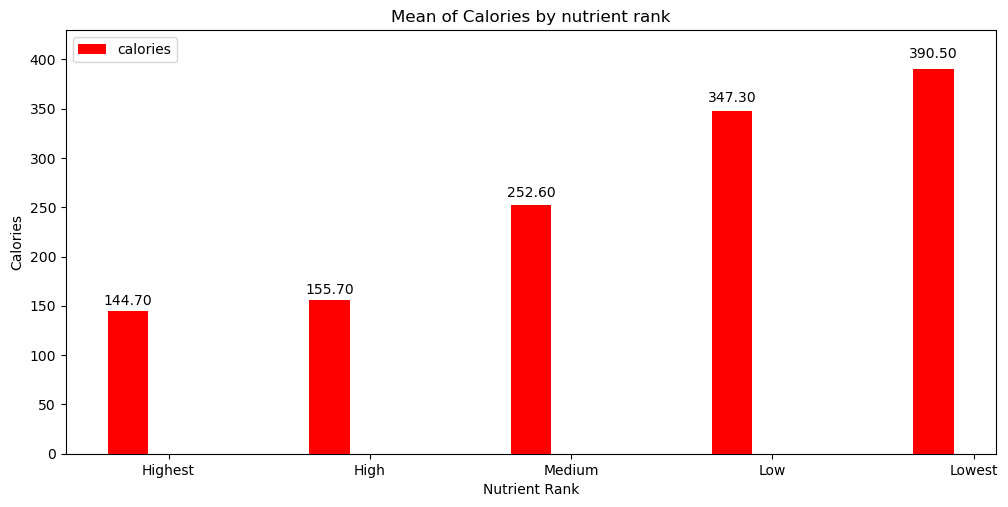

In [70]:
# Select the mean statistic for each nutrient group to compare

ranker = ['Highest','High','Medium','Low','Lowest']
selected_value_0 = ['calories']
rank_value_0 = []
for r in ranker:
    rank_value_0.append(test_category_food[selected_value_0][(test_category_food['NutriRank'] == r)].mean(axis=0,numeric_only=True))
rank_value_0_array = np.asarray(rank_value_0)
    
checkNutrient(rank_value_0_array,ranker,selected_value_0,'calories')

## Macronutrients for each nutrient group
Fat, Protein, Carbohydrate are the main nutrient in every foods.

The graph show that Highest and High nutrient group have balance in protein and carbohydrate with low fat.
While Low and Lowest nutrient group have high in fat and carboyhydrate.

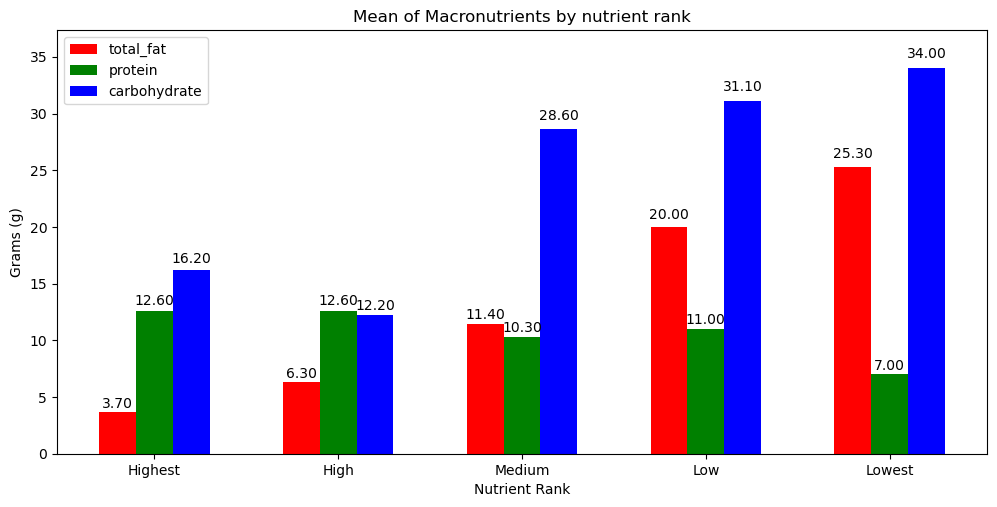

In [71]:
selected_value_1 = ['total_fat','protein','carbohydrate'] 
rank_value_1 = []
for r in ranker:
    rank_value_1.append(test_category_food[selected_value_1][(test_category_food['NutriRank'] == r)].mean(axis=0,numeric_only=True))
rank_value_1_array = np.asarray(rank_value_1)
    
checkNutrient(rank_value_1_array,ranker,selected_value_1,'nutrient')

## Macronutrients for each nutrient group
Fiber, Sugars, Saturated_fat are the m
Fibers cannot broke down to sugar molecule which pereceive as healthy indicator. 
while high sugars could increase blood sugard associate with diabetes.
As saturated fat is associated with raised levels of non-HDL(bad).

The graph show that Sugars and Saturated fat trend are increased when move toward medium, low, and lowest nutrient group.

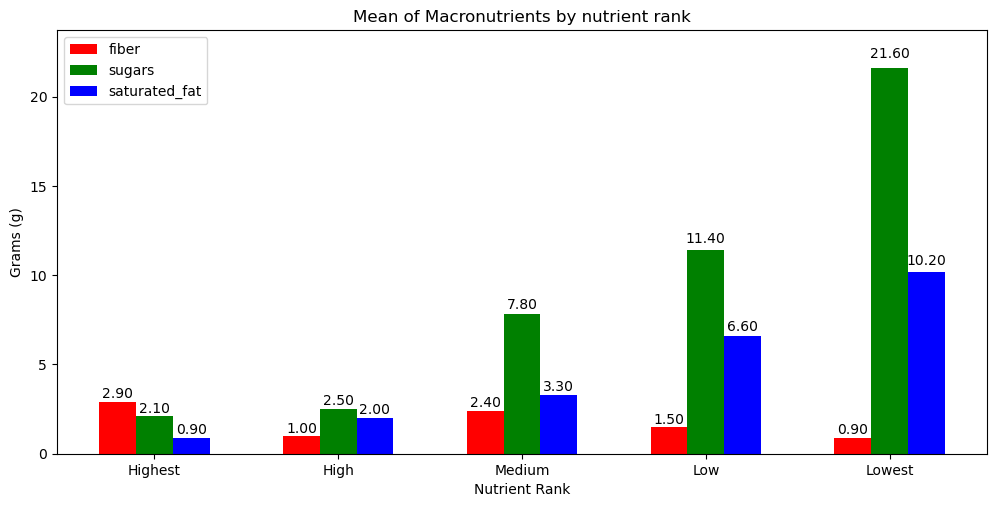

In [72]:
selected_value_f = ['fiber','sugars','saturated_fat'] 
rank_value_f = []
for r in ranker:
    rank_value_f.append(test_category_food[selected_value_f][(test_category_food['NutriRank'] == r)].mean(axis=0,numeric_only=True))
rank_value_f_array = np.asarray(rank_value_f)
    
checkNutrient(rank_value_f_array,ranker,selected_value_f,'nutrient')

## Minerals for each nutrient group
The graph show that Nutrient groups that contain high in sodium are Medium, Low, Lowest groups. 

As processd foods contain high sodium, so these group may contain those process foods.

While high potassium food come from fruits and vegetables as it likely to be in highest nutrient group.

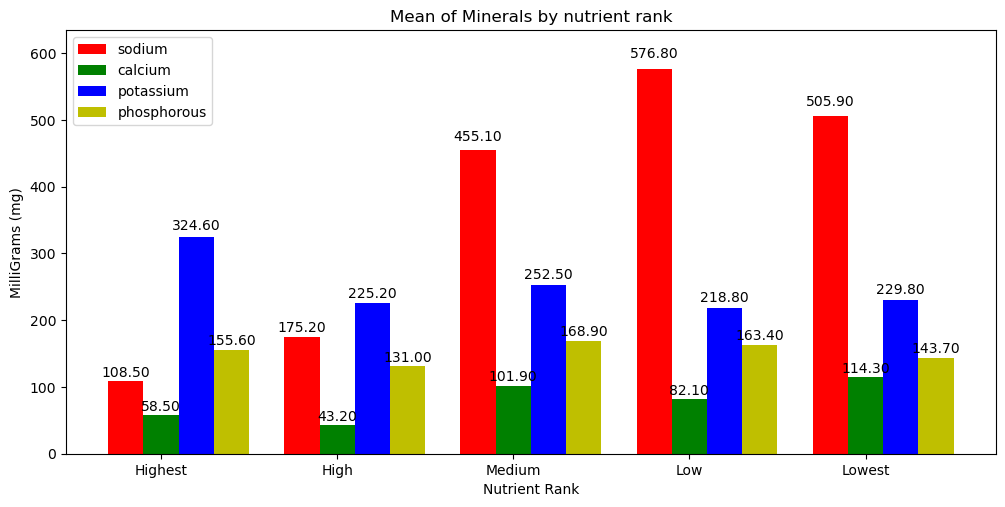

In [73]:
selected_value_2 = ['sodium', 'calcium', 'potassium', 'phosphorous']
#['sodium','fiber','vitamin_a','vitamin_c','NutriRank']

rank_value_2 = []
for r in ranker:
    rank_value_2.append(test_category_food[selected_value_2][(test_category_food['NutriRank'] == r)].mean(axis=0,numeric_only=True))
rank_value_2_array = np.asarray(rank_value_2)
    
checkNutrient(rank_value_2_array,ranker,selected_value_2,'minerals')

## Minerals for each nutrient group
Minerals like copper, iron, zinc, manganese aren't show any different in value between nutrient group.

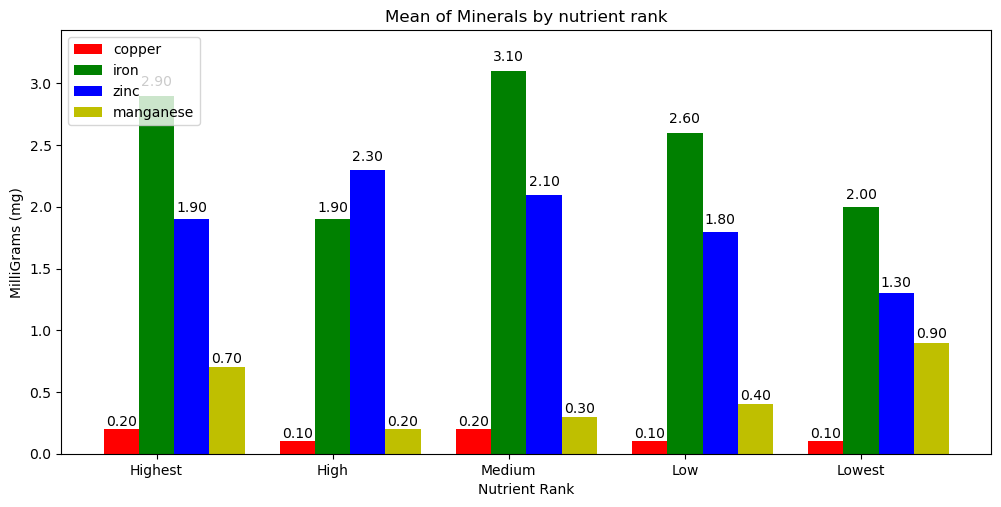

In [74]:
selected_value_3 = ['copper', 'iron', 'zinc', 'manganese']

rank_value_3 = []
for r in ranker:
    rank_value_3.append(test_category_food[selected_value_3][(test_category_food['NutriRank'] == r)].mean(axis=0,numeric_only=True))
rank_value_3_array = np.asarray(rank_value_3)
    
checkNutrient(rank_value_3_array,ranker,selected_value_3,'minerals')

## Vitamins for each nutrient group

The following vitamins have different units while the result doesn't show much different except for vitaminD in Lowest nutrient group, which likely came from high fat foods.

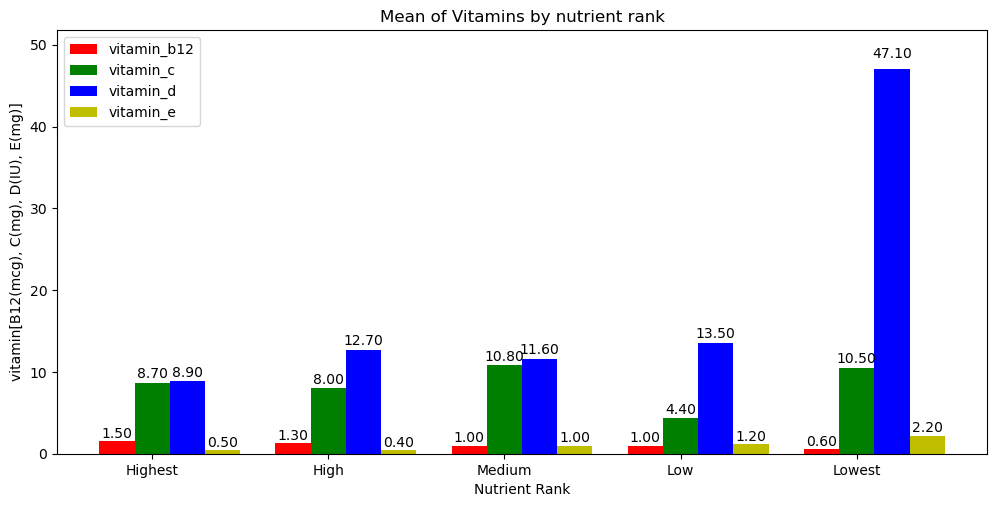

In [75]:
selected_value_4 = ['vitamin_b12', 'vitamin_c', 'vitamin_d', 'vitamin_e']

rank_value_4 = []
for r in ranker:
    rank_value_4.append(test_category_food[selected_value_4][(test_category_food['NutriRank'] == r)].mean(axis=0,numeric_only=True))
rank_value_4_array = np.asarray(rank_value_4)
    
checkNutrient(rank_value_4_array,ranker,selected_value_4,'vitamins')

In [76]:
# Sample food from each nutrient group

import random

sample = []

for r in ranker:
    sample.append(np.random.choice(test_category_food[selected_value_4][(test_category_food['NutriRank'] == r)].index, size=5, replace=False))
    
sample_array = np.asarray(sample)

In [77]:
test_category_food.loc[sample_array[0]][['name','NutriRank','category','calories','total_fat','protein','carbohydrate','sugars','fiber','sodium','potassium','points_a','NutriScore','FVLN (%)']]

,name,NutriRank,category,calories,total_fat,protein,carbohydrate,sugars,fiber,sodium,potassium,points_a,NutriScore,FVLN (%)
6833,"Fast foods, turkey breast on white bread with ...",Highest,vegetables,147,2.3,9.12,22.42,3.09,1.3,317.0,253.0,4.0,-7.0,>80
6314,"Game meat, raw, trimmed to 0"" fat, separable l...",Highest,food,116,2.4,22.10,0.00,0.00,0.0,48.0,344.0,1.0,-4.0,<=40
6786,"Fish, drained solids, without salt, canned in ...",Highest,food,128,3.0,23.62,0.00,0.00,0.0,50.0,237.0,1.0,-4.0,<=40
5143,"Pork, raw, separable lean only, whole, leg (ha...",Highest,food,136,5.4,20.48,0.00,0.00,0.0,55.0,369.0,2.0,-3.0,<=40
5716,"Fish, canned (Alaska Native), kippered, chinoo...",Highest,food,266,16.0,30.70,0.00,0.00,0.0,0.0,0.0,3.0,-2.0,<=40


In [78]:
test_category_food.loc[sample_array[3]][['name','NutriRank','category','calories','total_fat','protein','carbohydrate','sugars','fiber','sodium','potassium','points_a','NutriScore','FVLN (%)']]

,name,NutriRank,category,calories,total_fat,protein,carbohydrate,sugars,fiber,sodium,potassium,points_a,NutriScore,FVLN (%)
4126,"KEEBLER, bite size, Pecan Shortbread Cookies, ...",Low,nuts,547,33.0,5.00,58.70,22.50,1.6,333.0,79.0,22.0,18.0,>60
5773,"KEEBLER, Reduced Fat, Pretzel Crackers, FLIPSI...",Low,food,450,16.0,7.20,70.40,7.50,2.3,1288.0,108.0,18.0,15.0,<=40
1575,"USDA Commodity, Flour Mix, Bakery",Low,food,400,13.0,8.47,62.53,0.00,7.1,1410.0,124.0,17.0,12.0,<=40
4409,"Cereals, dry, Banana Bread, Instant Oatmeal, Q...",Low,fruits,368,4.9,8.97,75.70,29.45,6.7,700.0,287.0,17.0,11.0,>40
708,"Seeds, high-fat, sesame flour",Low,food,526,37.0,30.78,26.62,0.00,0.0,41.0,423.0,11.0,11.0,<=40


## Explore further on different model in building Classification model based on label of nutrient quality to predict any food with nutrient label 

In [79]:
# Check percentage of each to decide wheather dataset is imbalance or need sampling
test_category_food.groupby('NutriRank(number)').count()['name'] * 100 / 8789

NutriRank(number)
0     9.523268
1    17.817727
2    18.591421
3    18.181818
4    35.885766
Name: name, dtype: float64

#### Only classes with lowest and highest nutrient rank that has low/high than the rest which is not in extrem imbalance case

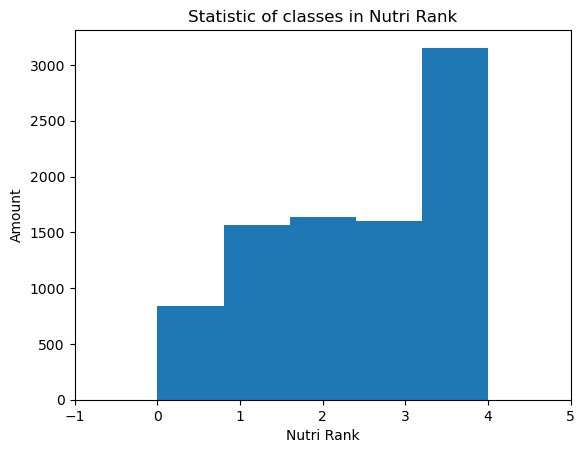

In [47]:
plt.hist(test_category_food['NutriRank(number)'], bins=5)
plt.xlim(-1,5)
plt.title("Statistic of classes in Nutri Rank")
plt.xlabel("Nutri Rank")
plt.ylabel("Amount")
plt.show()

### First Model to explore is deep learning

In [356]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.utils import np_utils
from scikeras.wrappers import KerasClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline

#### Select input feature by choosing only nutrients that important from graph bar analyze above

In [210]:
SEED = 7

feature_selection = ['calories','total_fat','protein','carbohydrate','sugars','fiber','saturated_fat','sodium','potassium','NutriRank(number)']
test_multi_clf_df = test_category_food[feature_selection].copy()

# Not using any scaler as model need to find relation on real nutrient value and rank
#X = StandardScaler().fit_transform(test_multi_clf_df[feature_selection[:-1]])
X = test_multi_clf_df[feature_selection[:-1]]

# Encode class values for one-hot-encoding in deep learning multi-class
encoder = LabelEncoder()
y_en = encoder.fit_transform(test_multi_clf_df[feature_selection[-1]])
y = np_utils.to_categorical(y_en)
y

array([[0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]], dtype=float32)

In [217]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

In [402]:
# Base model before tunning
def base_model():
    model = Sequential()
    model.add(Dense(20, input_dim=9, activation='relu'))
    model.add(Dense(40, input_dim=9, activation='sigmoid'))
    model.add(Dense(5, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
    return model

In [403]:
model = base_model()
train = model.fit(X_train, y_train, epochs=100, 
                  batch_size=20, verbose=1 ,validation_data=(X_test,y_test))

Epoch 1/100
352/352 [==============================] - 1s 2ms/step - loss: 1.3587 - accuracy: 0.4418 - val_loss: 1.2838 - val_accuracy: 0.4881
Epoch 2/100
352/352 [==============================] - 1s 2ms/step - loss: 1.2496 - accuracy: 0.4992 - val_loss: 1.2246 - val_accuracy: 0.5068
Epoch 3/100
352/352 [==============================] - 1s 2ms/step - loss: 1.1933 - accuracy: 0.5204 - val_loss: 1.1509 - val_accuracy: 0.5404
Epoch 4/100
352/352 [==============================] - 0s 1ms/step - loss: 1.1304 - accuracy: 0.5449 - val_loss: 1.0879 - val_accuracy: 0.5609
Epoch 5/100
352/352 [==============================] - 1s 2ms/step - loss: 1.0777 - accuracy: 0.5534 - val_loss: 1.0490 - val_accuracy: 0.5597
Epoch 6/100
352/352 [==============================] - 1s 1ms/step - loss: 1.0391 - accuracy: 0.5605 - val_loss: 1.0350 - val_accuracy: 0.5882
Epoch 7/100
352/352 [==============================] - 0s 1ms/step - loss: 1.0157 - accuracy: 0.5810 - val_loss: 0.9994 - val_accuracy: 0.5705

Epoch 58/100
352/352 [==============================] - 0s 1ms/step - loss: 0.7922 - accuracy: 0.6736 - val_loss: 0.8533 - val_accuracy: 0.6485
Epoch 59/100
352/352 [==============================] - 0s 1ms/step - loss: 0.7879 - accuracy: 0.6764 - val_loss: 0.8103 - val_accuracy: 0.6684
Epoch 60/100
352/352 [==============================] - 0s 1ms/step - loss: 0.7809 - accuracy: 0.6841 - val_loss: 0.8196 - val_accuracy: 0.6706
Epoch 61/100
352/352 [==============================] - 0s 1ms/step - loss: 0.7882 - accuracy: 0.6840 - val_loss: 0.8060 - val_accuracy: 0.6792
Epoch 62/100
352/352 [==============================] - 0s 1ms/step - loss: 0.7829 - accuracy: 0.6813 - val_loss: 0.8024 - val_accuracy: 0.6797
Epoch 63/100
352/352 [==============================] - 0s 1ms/step - loss: 0.7878 - accuracy: 0.6767 - val_loss: 0.8005 - val_accuracy: 0.6803
Epoch 64/100
352/352 [==============================] - 0s 1ms/step - loss: 0.7807 - accuracy: 0.6769 - val_loss: 0.8025 - val_accuracy:

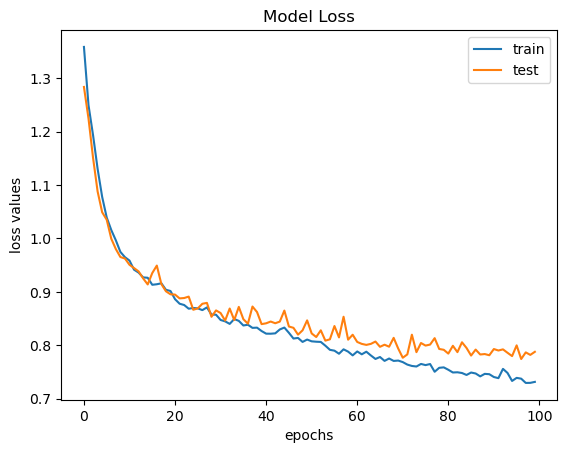

In [404]:
# Plot Model loss for base model
plt.plot(train.history['loss'], label='train')
plt.plot(train.history['val_loss'], label='test')
plt.title('Model Loss')
plt.xlabel('epochs')
plt.ylabel('loss values')
plt.legend(loc='upper right')
plt.show()

In [405]:
# Tuning params on epochs and batch_size by using gridsearchCV
param_grid = {
    'epochs': [200,400,1000], 
    'batch_size': [20,32,50],
}

model_cv = KerasClassifier(model=base_model, verbose=0)
grid = GridSearchCV(estimator=model_cv, n_jobs=-1, verbose=0, cv=5, param_grid=param_grid)
grid_cv_model = grid.fit(X_train, y_train)

In [415]:
print("Best: %f Params: %s" % (grid_cv_model.best_score_, grid_cv_model.best_params_))
# best params batch_size': 20, 'epochs': 1000

Best: 0.726927 Params: {'batch_size': 20, 'epochs': 1000}


In [406]:
# Using kfold crossvalidation with best params
cv_model = grid_cv_model.best_estimator_
kfold = KFold(n_splits=5, shuffle=True)
results = cross_val_score(cv_model, X_train, y_train, cv=kfold, scoring='accuracy')

In [407]:
print('K-fold Cross Validation accuracy Results: ', results)
print('K-fold Cross Validation accuracy Results Mean: ', results.mean())

K-fold Cross Validation accuracy Results:  [0.71855011 0.72332859 0.74893314 0.68847795 0.69487909]
K-fold Cross Validation accuracy Results Mean:  0.7148337766562433


In [408]:
kfold = KFold(n_splits=5, shuffle=True)
results = cross_val_score(cv_model, X_train, y_train, cv=kfold, scoring='f1_weighted')

In [409]:
print('K-fold Cross Validation f1_weighted Results: ', results)
print('K-fold Cross Validation f1_weighted Results Mean: ', results.mean())

K-fold Cross Validation f1_weighted Results:  [0.71128305 0.69277171 0.71853335 0.73464459 0.72185821]
K-fold Cross Validation f1_weighted Results Mean:  0.7158181825043444


In [598]:
import sklearn.metrics as metrics

# Check score and metrics of model
y_pred = cv_model.predict(X_test) 

print("F1_weighted:",metrics.f1_score(y_test, y_pred,average='weighted'))
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

F1_weighted: 0.7375952243433259
Accuracy: 0.7389078498293515


In [537]:
from sklearn.metrics import classification_report 

# Classification Report for each multi-class
model_report = classification_report(y_test, y_pred)
print(model_report)

              precision    recall  f1-score   support

           0       0.66      0.60      0.63       174
           1       0.73      0.68      0.70       328
           2       0.57      0.71      0.63       310
           3       0.74      0.59      0.66       302
           4       0.85      0.90      0.87       644

   micro avg       0.74      0.74      0.74      1758
   macro avg       0.71      0.69      0.70      1758
weighted avg       0.74      0.74      0.74      1758
 samples avg       0.74      0.74      0.74      1758



In [538]:
from scipy import interp
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Learn to predict each class against the other

y_score = cv_model.predict_proba(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(5):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

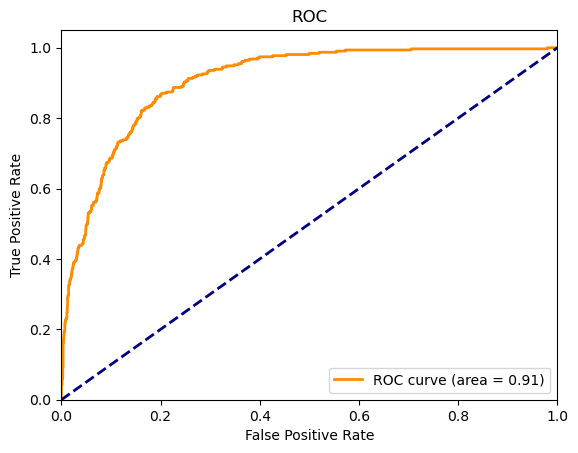

In [539]:
plt.figure()
plt.plot(fpr[2], tpr[2], color='darkorange',
         lw=2, label='ROC curve (area = %0.2f)' % roc_auc[2]) # Drawing Curve according to 2. class 
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

### Gradient Boosting Classifier model

In [626]:
# Use KFold on model to check crossvalidation score for each model
from sklearn.ensemble import GradientBoostingClassifier

score = cross_val_score(GradientBoostingClassifier(), X, np.argmax(y,axis=1), cv= kfold, scoring='accuracy')
print(f'Scores for each fold: {score}')
print(f'Scores mean: {np.mean(score)}')

Scores for each fold: [0.7559727  0.78725825 0.76734926 0.76734926 0.77575413]
Scores mean: 0.770736718330643


### Logistic Regression model

In [627]:
from sklearn.linear_model import LogisticRegression

score = cross_val_score(LogisticRegression(multi_class='multinomial', solver='newton-cg'), X, np.argmax(y,axis=1), cv=kfold, scoring="accuracy")
print(f'Scores for each fold: {score}')
print(f'Scores mean: {np.mean(score)}')

Scores for each fold: [0.60182025 0.61660978 0.61547213 0.60352673 0.59817871]
Scores mean: 0.6071215220379654


### Select Gradient Boosting Classifier model from crossvalidation score to perform gridsearchcv on params

In [570]:
param_grid_gradient = {
    'n_estimators': [100,200,400], 
    'learning_rate': [0.01,0.1,1.0],
    'max_depth': [1,2]
}

grid_gradient = GridSearchCV(estimator=GradientBoostingClassifier(random_state=SEED), n_jobs=-1, verbose=0, cv=5, param_grid=param_grid_gradient)
grid_cv_gradient = grid_gradient.fit(X_train, np.argmax(y_train, axis=1))

In [571]:
print("Best: %f Params: %s" % (grid_cv_gradient.best_score_, grid_cv_gradient.best_params_))
#BestParams: {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 400}

Best: 0.758218 Params: {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 400}


In [573]:
# Using kfold crossvalidation with best params
cv_model_gradient = grid_cv_gradient.best_estimator_
kfold = KFold(n_splits=5, shuffle=True)
results_gradient = cross_val_score(cv_model_gradient, X_train, np.argmax(y_train,axis=1), cv=kfold, scoring='accuracy')

In [574]:
print('K-fold Cross Validation accuracy (Gradient) Results: ', results_gradient)
print('K-fold Cross Validation accuracy (Gradient) Results Mean: ', results_gradient.mean())

K-fold Cross Validation accuracy (Gradient) Results:  [0.77683014 0.76529161 0.75817923 0.78307255 0.74537696]
K-fold Cross Validation accuracy (Gradient) Results Mean:  0.7657500952866231


In [578]:
import sklearn.metrics as metrics

# Check score and metrics of model
y_pred_gradient = cv_model_gradient.predict(X_test) 

print("F1_weighted:",metrics.f1_score(np.argmax(y_test,axis=1), y_pred_gradient,average='weighted'))
print("Accuracy:",metrics.accuracy_score(np.argmax(y_test,axis=1), y_pred_gradient))

F1_weighted: 0.7761166022393359
Accuracy: 0.7764505119453925


In [579]:
from sklearn.metrics import classification_report 

# Classification Report for each multi-class
model_report_gra = classification_report(np.argmax(y_test,axis=1), y_pred_gradient)
print(model_report_gra)

              precision    recall  f1-score   support

           0       0.78      0.59      0.67       174
           1       0.75      0.75      0.75       328
           2       0.63      0.72      0.67       310
           3       0.72      0.70      0.71       302
           4       0.90      0.91      0.90       644

    accuracy                           0.78      1758
   macro avg       0.75      0.73      0.74      1758
weighted avg       0.78      0.78      0.78      1758



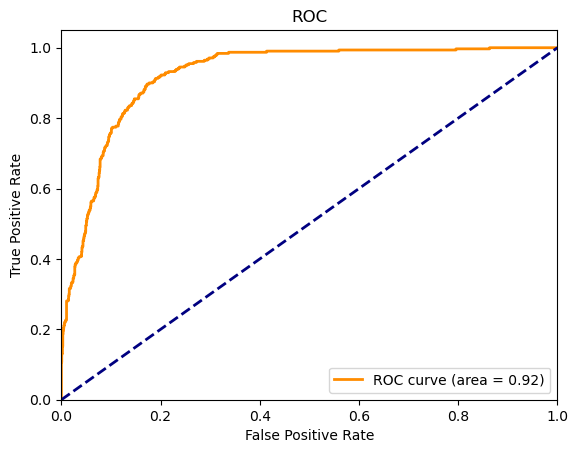

In [629]:
# Learn to predict each class against the other

y_score = cv_model_gradient.predict_proba(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(5):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()
plt.plot(fpr[2], tpr[2], color='darkorange',
         lw=2, label='ROC curve (area = %0.2f)' % roc_auc[2]) # Drawing Curve according to 2. class 
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

### Make prediction function that take features (calrories, fat, etc.) to predict any food with nutrients label

In [622]:
def predict_NutriRank(model, nutrients):
    
    predictions = model.predict(nutrients)
    
    if len(predictions.shape) == 2:
        predictions = np.argmax(predictions, axis=1)
        
    rank_list = np.zeros_like(predictions).astype(str)
    rank = ''
    
    for i,value in enumerate(predictions):
        
        if value == 0: rank = 'Lowest'
        if value == 1: rank = 'Low'
        if value == 2: rank = 'Medium'
        if value == 3: rank = 'High'
        if value == 4: rank = 'Highest'
            
        rank_list[i] = rank
        
    return rank_list

In [623]:
# Serving Size: 100g Input by Order
# 'calories','total_fat','protein','carbohydrate','sugars','fiber','saturated_fat','sodium','potassium',

Doritos = ['497', '24.9', '6.1', '59.3', '6.1', '5.6', '3.0', '135', '0']
Walnuts = ['712', '69.1', '15.51', '3.7', '3.0', '6.8', '6.8', '2', '0']
Salsa = ['38', '0.2', '1.5', '7.1', '5.1', '0.9', '0.1', '127', '0']
PizzaC = ['276', '11.74', '12.33', '30.33', '3.56', '1.9', '5.005', '127', '0']
CCake = ['321', '22.5', '5.5', '25.5', '0', '0.4', '9.921', '52', '90']

input_foods = np.array([Doritos,Walnuts,Salsa,PizzaC,CCake]).astype(float)

print("Deep Learning Model prediction:", predict_NutriRank(cv_model,input_foods))

print("Gradient Boosting Model prediction:", predict_5NutriRank(cv_model_gradient, input_foods))

Deep Learning Model prediction: ['Medium' 'Medium' 'Highest' 'Medium' 'Low']
Gradient Boosting Model prediction: ['Medium' 'Medium' 'Highest' 'Medium' 'Low']


C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(


#### The deep learning and gradient boosting model have a similar predictions as the score in each fields of both models perform very close.

### Test using K-mean cluster classification without using NutriRank,  just datasets to see how algorithm interpret data points

In [2288]:
test_cluster_df = nutrition_df[['name','calories','total_fat','protein','carbohydrate','sodium','potassium']]
test_cluster_df

,name,calories,total_fat,protein,carbohydrate,sodium,potassium
0,Cornstarch,381,0.1,0.26,91.27,9.0,3.0
1,"Nuts, pecans",691,72.0,9.17,13.86,0.0,410.0
2,"Eggplant, raw",25,0.2,0.98,5.88,2.0,229.0
3,"Teff, uncooked",367,2.4,13.30,73.13,12.0,427.0
4,"Sherbet, orange",144,2.0,1.10,30.40,46.0,96.0
...,...,...,...,...,...,...,...
8784,"Beef, raw, all grades, trimmed to 0"" fat, sepa...",125,3.5,23.45,0.00,54.0,311.0
8785,"Lamb, cooked, separable lean only, composite o...",206,8.9,29.59,0.00,50.0,188.0
8786,"Lamb, raw, separable lean and fat, composite o...",277,23.0,16.74,0.00,39.0,136.0
8787,"Beef, raw, all grades, trimmed to 0"" fat, sepa...",121,3.0,23.37,0.00,53.0,319.0


### PCA for plotting data

In [2290]:

from sklearn.decomposition import PCA

features = test_cluster_df[test_cluster_df.columns[1:]]

# Normalize the numeric features so they're on the same scale
scaled_features = MinMaxScaler().fit_transform(features)

# Get two principal components
pca = PCA(n_components=2).fit(scaled_features)
features_2d = pca.transform(scaled_features)
features_2d[0:5]

array([[ 0.67500535, -0.27904764],
       [ 0.26401217,  0.74451224],
       [-0.24954032, -0.155337  ],
       [ 0.50030761, -0.16983385],
       [ 0.02701322, -0.16697077]])

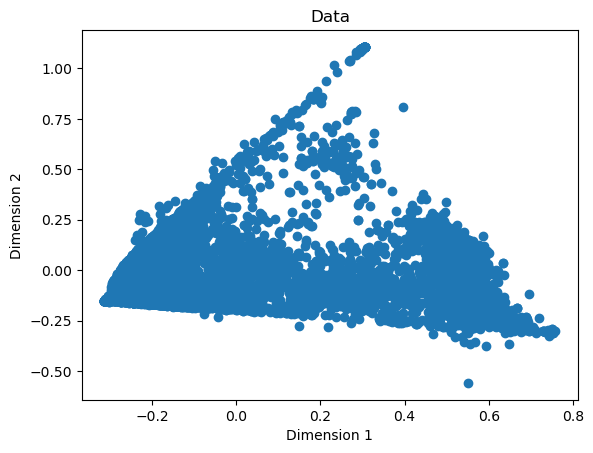

In [2291]:
plt.scatter(features_2d[:,0],features_2d[:,1])
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('Data')
plt.show()

### Standardize the data

In [2293]:
scale= StandardScaler()
 
# standardization of dependent variables
scaled_data = scale.fit_transform(features) 
#print(scaled_data)

### Elbow method

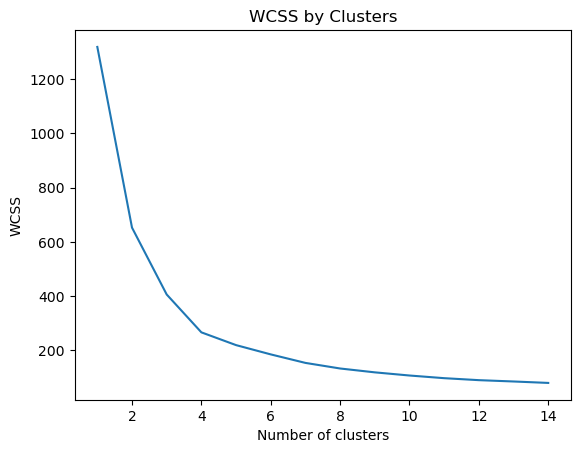

In [2295]:
from sklearn.cluster import KMeans
%matplotlib inline

# Create 15 models with 1 to 15 clusters
wcss = []
for i in range(1, 15):
    kmeans = KMeans(n_clusters = i)
    # Fit the data points
    kmeans.fit(scaled_features)
    # Get the WCSS (inertia) value
    wcss.append(kmeans.inertia_)
    
#Plot the WCSS values onto a line graph
plt.plot(range(1, 15), wcss)
plt.title('WCSS by Clusters')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

### K-mean for 4 clusters and plotting

In [2296]:
model = KMeans(n_clusters=4, init='k-means++', n_init=500, max_iter=1500)
# Fit to the data and predict the cluster assignments for each data point
km_clusters = model.fit_predict(scaled_features)
# View the cluster assignments
km_clusters

array([1, 2, 3, ..., 0, 0, 0])

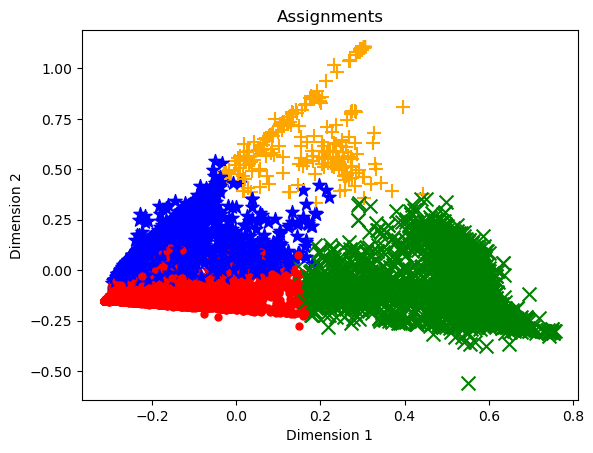

In [2297]:
def plot_clusters(samples, clusters):
    col_dic = {0:'blue',1:'green',2:'orange', 3:'red'}
    mrk_dic = {0:'*',1:'x',2:'+', 3:'.'}
    colors = [col_dic[x] for x in clusters]
    markers = [mrk_dic[x] for x in clusters]
    for sample in range(len(clusters)):
        plt.scatter(samples[sample][0], samples[sample][1], color = colors[sample], marker=markers[sample], s=100)
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.title('Assignments')
    plt.show()

plot_clusters(features_2d, km_clusters)

### Assign cluster for investigate group data insight

In [2298]:
test_cluster_df['Cluster-group'] = km_clusters.astype(str)

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_20064\472222658.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_cluster_df['Cluster-group'] = km_clusters.astype(str)


In [2299]:
summary_nutri = []

for i in range(4):
    summary_nutri.append(np.mean(test_cluster_df[test_cluster_df['Cluster-group'] == str(i)], axis=0)[:-1])
    
summary_nutri_df = pd.DataFrame(np.asarray(summary_nutri), columns = test_cluster_df.columns[1:-1])
summary_nutri_df

C:\Users\Lenovo\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3438: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


,calories,total_fat,protein,carbohydrate,sodium,potassium
0,211.696104,11.821558,22.718510,2.928393,301.062987,295.118831
1,389.396601,11.344854,7.896596,66.584207,423.127479,353.674693
2,688.245810,71.466480,8.532709,7.386732,214.150838,236.581006
3,82.168574,2.091061,3.081939,12.910690,245.103619,182.043922


#### The descriptive statistic of each cluster group can be describe below
In serving size of 100g can explain nutrition

Cluster 0: Consist of high protein food

Cluster 1: Consist of high carbohydrate food

Cluster 2: Consist of high calories food mainly from fat

Cluster 3: Consist of low calories food

### Check the dataset information by take random sample for each cluster group

In [2327]:
import random

sample = []
for i in range(4):
    sample.append(np.random.choice(test_cluster_df[test_cluster_df['Cluster-group'] == str(i)].index, size=6, replace=False))

sample_array = np.asarray(sample)

In [2328]:
test_cluster_df.loc[sample_array[0]]

,name,calories,total_fat,protein,carbohydrate,sodium,potassium,Cluster-group
4074,"WORTHINGTON Prosage Roll, unprepared, frozen",261,18.0,19.60,6.0,667.0,139.0,0
1855,"Squab, raw, meat only, (pigeon)",142,7.5,17.50,0.0,51.0,237.0,0
6596,"Chicken, raw, with added solution, meat only, ...",106,3.3,19.19,0.0,152.0,192.0,0
204,"Fish, raw, swordfish",144,6.7,19.66,0.0,81.0,418.0,0
6993,"Beef, raw, choice, trimmed to 1/8"" fat, separa...",199,13.0,19.48,0.0,58.0,326.0,0
3563,"Veal, roasted, cooked, separable lean only, loin",175,6.9,26.32,0.0,96.0,340.0,0


In [2329]:
#test_cluster_df.loc[sample_array[1]]
#test_cluster_df.loc[sample_array[2]]
test_cluster_df.loc[sample_array[3]]

,name,calories,total_fat,protein,carbohydrate,sodium,potassium,Cluster-group
4116,"Tomato products, with herbs and cheese, sauce,...",59,1.9,2.13,10.24,543.0,356.0,3
174,"Pears, bartlett, raw",63,0.2,0.39,15.01,1.0,101.0,3
6947,"Potatoes, oven-heated, frozen, salt added in p...",199,6.8,2.90,31.66,400.0,505.0,3
4034,"VAN'S, Totally Original Pancakes, Gluten Free",215,4.6,3.31,40.32,331.0,127.0,3
7481,"Split pea with ham soup, prepared with water o...",68,0.7,4.00,11.40,196.0,204.0,3
4140,"Beans, with salt, boiled, cooked, mature seeds...",143,0.7,9.01,26.22,238.0,436.0,3


### From the cluster group, we could use this information to give advice in nutrition consumption for people who looking for low calories food, keto diet, or people who controlling their macro food consumption. While it might overlook some factors like minerals and vitamins as a result from graph show by nutrient group score.